### Lab08


### 2021-10-21

elements from https://nbviewer.ipython.org/

### Regularized Linear Regression


- Earlier we covered Ordinary Least Squares regression. 

- Here,  extension to linear regression, <a href="http://en.wikipedia.org/wiki/Regularization_(mathematics)" target="_blank">regularization</a>, that makes it applicable for [ill-posed problems](http://en.wikipedia.org/wiki/Ill-posed_problem) (e.g. number of predictors >> number of samples) and helps to prevent [overfitting](http://en.wikipedia.org/wiki/Overfitting).

- We considered linear regression and polynomial regression. [Polynomial regression](http://en.wikipedia.org/wiki/Polynomial_regression) fits a n-th order polynomial to our data using least squares. 

- Question: What should be a degree of the polynomial?

- Clearly, the higher the order of the polynomial, the higher the complexity of the model. 

### Synthetic data: sinus plus some random gaussian noise

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'x')

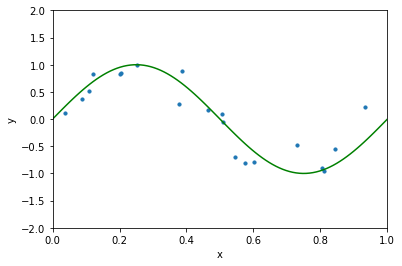

In [1]:
%pylab inline

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# ignore DeprecateWarnings by sklearn
import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)

def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

ax = plt.gca()
ax.plot(x_plot, f(x_plot), color='green')
ax.scatter(X_train, y_train, s=10)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')

Below how different polynomials can approximate this curve.

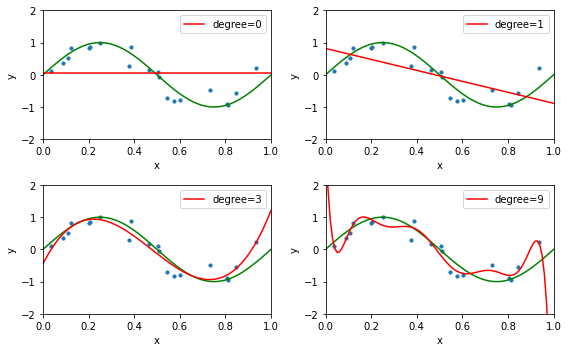

In [2]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(X_train, y_train, s=10)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')  #, fontsize='small')

fig, axes = plt.subplots(2, 2, figsize=(8, 5))
# fit different polynomials and plot approximations
for ax, degree in zip(axes.ravel(), [0, 1, 3, 9]):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    plot_approximation(est, ax, label='degree=%d' % degree)
    
plt.tight_layout()

- The polynomial of degree zero is just a constant approximation

- The polynomial of degree one fits a straight line

- The polynomial of degree three nicely approximates the ground truth


- The polynomial of degree nine has nearly zero training error; but it already fits the variance induced by the random gaussian noise
---

- Plotting the higher the degree of the polynomial, the lower the training error. 

- The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven (*overfitting*: the model is already so complex)


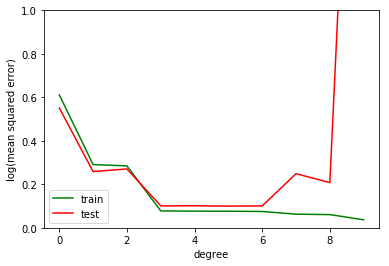

In [9]:
from sklearn.metrics import mean_squared_error

train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='lower left')

- In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. 

- We can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. 



- A popular regularized linear regression model is Ridge Regression, which adds the L2 norm to the OSL:

  $J(\boldsymbol w) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol w^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol w\|_2$

where $\boldsymbol w$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. 


- The L2 norm term is weighted by a regularization parameter ``alpha``


- Below is the ``sklearn.linear_model.RidgeRegression`` estimator fitting a polynomial of degree nine for various values of ``alpha``

- The smaller the value of ``alpha`` the higher the magnitude of the coefficients

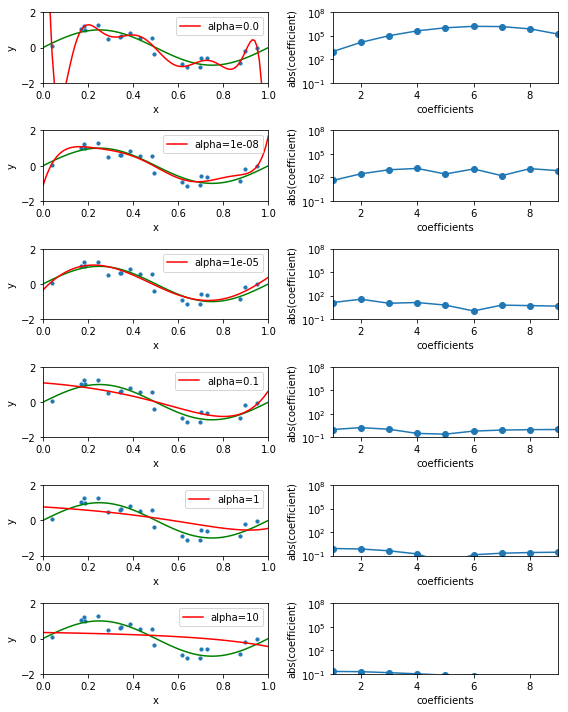

In [15]:
alphas = [0.0, 1e-8, 1e-5, 0.1, 1, 10]

fig, ax_rows = plt.subplots(len(alphas), 2, figsize=(8, 10))

def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

degree = 9
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

## Regularization techniques

- In the above example we used Ridge Regression, [L2 norm](http://mathworld.wolfram.com/L2-Norm.html)


- Another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. 


- The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero. 



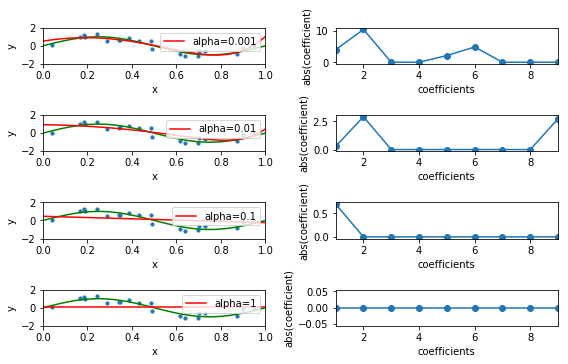

In [17]:
from sklearn.linear_model import Lasso

alphas = [1e-3, 1e-2, 1e-1, 1]
fig, ax_rows = plt.subplots(len(alphas), 2, figsize=(8, 5))

degree = 9
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()